### Data download

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

!kaggle datasets download -d jessicali9530/celeba-dataset # 다운로드
!unzip -q celeba-dataset.zip -d . # 압축 풀기

100% 1.33G/1.33G [00:34<00:00, 42.6MB/s]
100% 1.33G/1.33G [00:34<00:00, 41.4MB/s]


### 데이터셋 만들기 (전처리)

<function matplotlib.pyplot.show(close=None, block=None)>

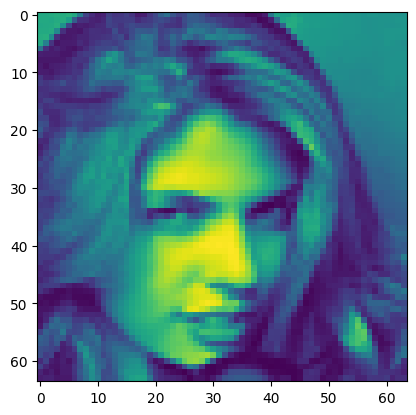

In [4]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

file_list = os.listdir('/content/img_align_celeba/img_align_celeba') # 폴더 내부의 모든 파일명을 [리스트]에 담아줌

images = []
for i in file_list[0:50000]:
  data = Image.open('/content/img_align_celeba/img_align_celeba/' + i).crop((20, 30, 160, 180)).convert('L').resize((64, 64)) # 이미지 전처리 : 사이즈 줄이기
  images.append(np.array(data))

plt.imshow(images[1])
plt.show

In [5]:
images = np.array(images)
print(images.shape)

(50000, 64, 64)


이미지 전처리 (255로 나누기)

In [6]:
images = np.divide(images, 255)
images = images.reshape(50000, 64, 64, 1) # 4차원으로 바꾸기
print(images.shape)

(50000, 64, 64, 1)


### Discriminator 만들기

Discriminator : 이미지를 입력했을 때 진짜인지 가짜인지 판정해주는 모델

In [7]:
import tensorflow as tf

discriminator = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=[64,64,1]),
  tf.keras.layers.LeakyReLU(alpha=0.2), # LeakyReLU() : 음수에 작은 숫자를 곱해줌
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'),
  tf.keras.layers.LeakyReLU(alpha=0.2),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

### Generator 만들기

In [8]:
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, Dropout, Flatten, Conv2D, Conv2DTranspose, BatchNormalization

noise_shape = 100

generator = tf.keras.models.Sequential([
  Dense(4 * 4 * 256, input_shape=(100,) ),
  Reshape((4, 4, 256)),
  Conv2DTranspose(256, 3, strides=2, padding='same'),
  LeakyReLU(alpha=0.2),
  BatchNormalization(),
  Conv2DTranspose(128, 3, strides=2, padding='same'),
  LeakyReLU(alpha=0.2),
  BatchNormalization(),
  Conv2DTranspose(64, 3, strides=2, padding='same'),
  LeakyReLU(alpha=0.2),
  BatchNormalization(),
  Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid')
])

generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)     

### GAN 전체 모델 만들기

In [9]:
GAN = tf.keras.models.Sequential([ generator, discriminator ])

discriminator.compile(optimizer='adam', loss='binary_crossentropy') # 확률이면 'binary_crossentropy'

discriminator.trainable = False # generator을 학습시킬 때 discriminator은 학습하면 안 됨
GAN.compile(optimizer='adam', loss='binary_crossentropy')

### generator 학습 전 Prediction

In [14]:
r = np.random.uniform(-1, 1, size=(10, 100)) # -1~1까지 랜덤으로 균일한 숫자
pred = generator.predict(r)

# print(pred)
print(pred.shape)

1/1 [==============================] - 0s 194ms/step
(10, 64, 64, 1)


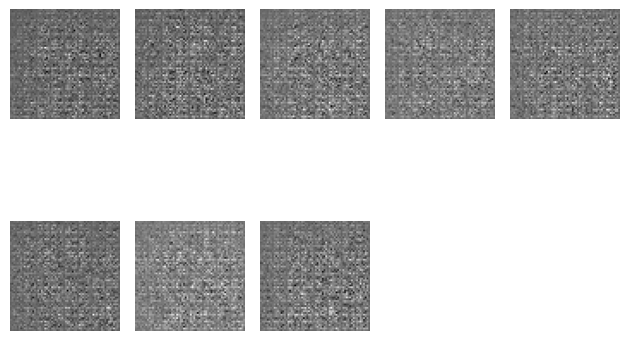

In [15]:
for i in range(8):
  plt.subplot(2, 5, i+1)
  plt.imshow(pred[i].reshape(64,64), cmap='gray') # color는 64, 64, 3
  plt.axis('off')
plt.tight_layout()
plt.show()

### training

예측 이미지 출력하는 함수

In [18]:
def predict_img():
  r = np.random.uniform(-1, 1, size=(10, 100)) # -1~1까지 랜덤으로 균일한 숫자
  pred = generator.predict(r)

  # print(pred)
  print(pred.shape)

  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(pred[i].reshape(64,64), cmap='gray') # color는 64, 64, 3
    plt.axis('off')
  plt.tight_layout()
  plt.show()

현재 epoch 0
1/1 [==============================] - 0s 25ms/step
(10, 64, 64, 1)


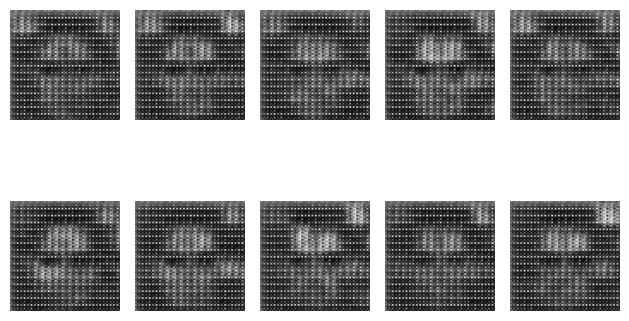

현재 batch 0
4/4 [==============================] - 0s 4ms/step
현재 batch 100
4/4 [==============================] - 0s 4ms/step
현재 batch 200
4/4 [==============================] - 0s 5ms/step
현재 batch 300
4/4 [==============================] - 0s 4ms/step
이번 epoch의 최종 loss : discriminator 0.15635961294174194, GAN 0.9049217700958252
현재 epoch 1
1/1 [==============================] - 0s 18ms/step
(10, 64, 64, 1)


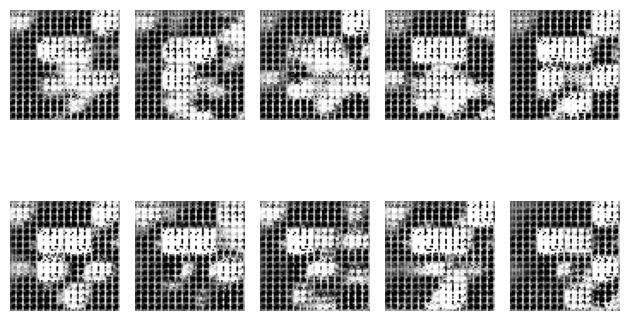

현재 batch 0
4/4 [==============================] - 0s 4ms/step
현재 batch 100
4/4 [==============================] - 0s 3ms/step
현재 batch 200
4/4 [==============================] - 0s 4ms/step
현재 batch 300
4/4 [==============================] - 0s 5ms/step
이번 epoch의 최종 loss : discriminator 0.7229976952075958, GAN 0.5952919721603394
현재 epoch 2
1/1 [==============================] - 0s 29ms/step
(10, 64, 64, 1)


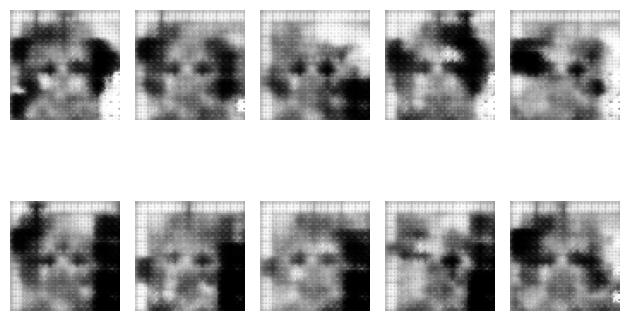

현재 batch 0
4/4 [==============================] - 0s 5ms/step
현재 batch 100
4/4 [==============================] - 0s 4ms/step
현재 batch 200
4/4 [==============================] - 0s 4ms/step
현재 batch 300
4/4 [==============================] - 0s 4ms/step
이번 epoch의 최종 loss : discriminator 0.995959460735321, GAN 0.9551181197166443
현재 epoch 3
1/1 [==============================] - 0s 18ms/step
(10, 64, 64, 1)


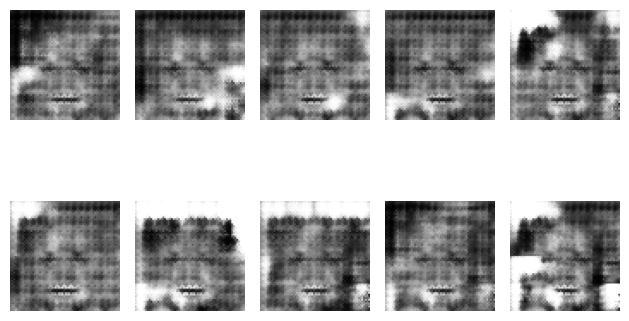

현재 batch 0
4/4 [==============================] - 0s 4ms/step
현재 batch 100
4/4 [==============================] - 0s 7ms/step
현재 batch 200
4/4 [==============================] - 0s 3ms/step
현재 batch 300
4/4 [==============================] - 0s 5ms/step
이번 epoch의 최종 loss : discriminator 1.2404553890228271, GAN 1.273162603378296
현재 epoch 4
1/1 [==============================] - 0s 33ms/step
(10, 64, 64, 1)


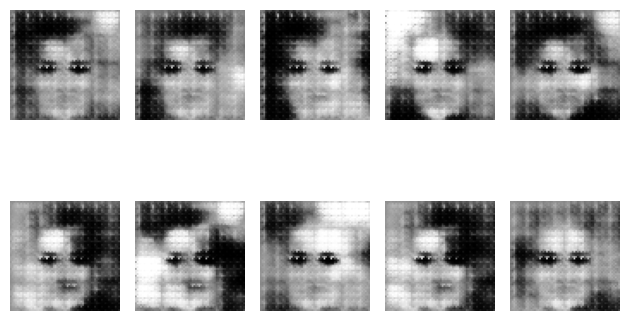

현재 batch 0
4/4 [==============================] - 0s 5ms/step
현재 batch 100
4/4 [==============================] - 0s 5ms/step
현재 batch 200
4/4 [==============================] - 0s 6ms/step
현재 batch 300
4/4 [==============================] - 0s 4ms/step
이번 epoch의 최종 loss : discriminator 1.0518437623977661, GAN 0.9380086660385132
현재 epoch 5
1/1 [==============================] - 0s 20ms/step
(10, 64, 64, 1)


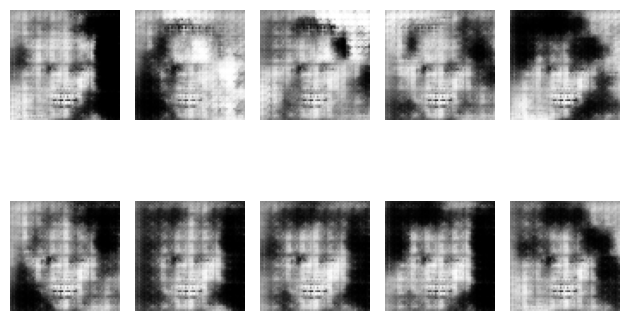

현재 batch 0
4/4 [==============================] - 0s 5ms/step
현재 batch 100
1/4 [======>.......................] - ETA: 0s

KeyboardInterrupt: ignored

In [20]:
X_data = images

for e in range(300): # epoch
  print(f'현재 epoch {e}')
  predict_img()

  for i in range(50000 // 128): # 128개씩 batch
    if i % 100 == 0:
      print(f'현재 batch {i}')

    # discriminator 트레이닝 : 실제 이미지 128장, 가짜 이미지 128장
    reals = X_data[i * 128 : (i + 1) * 128]
    ans1 = np.ones(shape=(128, 1))
    loss1 = discriminator.train_on_batch(reals, ans1)

    r = np.random.uniform(-1, 1, size=(128, 100))
    fakes = generator.predict(r)
    ans0 = np.zeros(shape=(128, 1))
    loss2 = discriminator.train_on_batch(fakes, ans0)

    # generator 트레이닝 = GAN 트레이닝[링크 텍스트](https://)
    r = np.random.uniform(-1, 1, size=(128, 100))
    ans1 = np.ones(shape=(128, 1))

    loss3 = GAN.train_on_batch(r, ans1)

  print(f'이번 epoch의 최종 loss : discriminator {loss1 + loss2}, GAN {loss3}')